AdaBeliefOptimizer 라이브러리 설치

In [1]:
!  pip install adabelief-tf==0.2.0

# 사용할 패키지

In [2]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from glob import glob
from tqdm import tqdm
import tensorflow as tf
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.optimizers import Adam
from adabelief_tf import AdaBeliefOptimizer

# TPU 장치 설정

In [3]:
try:
    tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  
    # TPU detection. No parameters necessary if TPU_NAME environment variable is set. On Kaggle this is always the case.
    print('Running on TPU ', tpu.master())
except ValueError:
    tpu = None

if tpu:
    tf.config.experimental_connect_to_cluster(tpu)
    tf.tpu.experimental.initialize_tpu_system(tpu)
    strategy = tf.distribute.experimental.TPUStrategy(tpu)
else:
    strategy = tf.distribute.get_strategy() 
    # default distribution strategy in Tensorflow. Works on CPU and single GPU.
print("REPLICAS: ", strategy.num_replicas_in_sync)

Running on TPU  grpc://10.121.126.26:8470
INFO:tensorflow:Initializing the TPU system: grpc://10.121.126.26:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.121.126.26:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


REPLICAS:  8


#구글 colab 경로 설정 및 데이터 가져오기

In [4]:
# from google.colab import drive
# drive.mount._DEBUG = True
# drive.mount('/content/drive', force_remount=True)

In [5]:
path = '/content/drive/MyDrive/python_project/dacon_북극/data/data_v2/'

In [6]:
train_csv = pd.read_csv(path+'train_v2.csv')

In [7]:
train_csv.head()

,month,file_nm
0,1978-11,197811.npy
1,1978-12,197812.npy
2,1979-01,197901.npy
3,1979-02,197902.npy
4,1979-03,197903.npy


2019년 데이터 확인

In [8]:
train_csv.tail()

,month,file_nm
489,2019-08,201908.npy
490,2019-09,201909.npy
491,2019-10,201910.npy
492,2019-11,201911.npy
493,2019-12,201912.npy


30년치 데이터만 활용

In [9]:
train_path = sorted(glob(path+'train_data_v2/*.npy'))
train_path = train_path[-30*12:]

In [10]:
train = []
for p in tqdm(train_path):
    train.append(np.load(p))
train = np.array(train)

100%|██████████| 360/360 [00:01<00:00, 246.40it/s]


In [11]:
train.shape

(360, 448, 304, 5)

In [12]:
train_19 = train[-12:, :, :, :1]

# 데이터 시각화

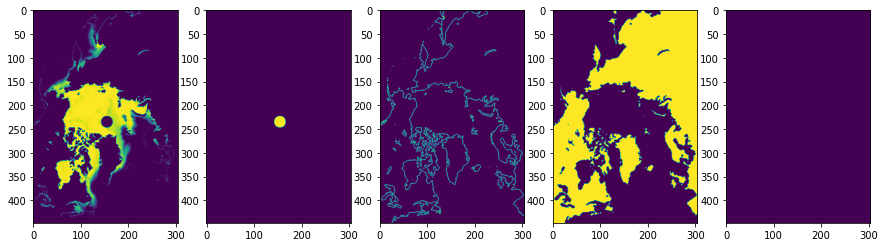

In [13]:
plt.figure(figsize=(15,10))
plt.subplot(151)
plt.imshow(train[0,:,:,0])
plt.subplot(152)
plt.imshow(train[0,:,:,1])
plt.subplot(153)
plt.imshow(train[0,:,:,2])
plt.subplot(154)
plt.imshow(train[0,:,:,3])
plt.subplot(155)
plt.imshow(train[0,:,:,4])

# 월별 데이터로 분리

In [14]:
train_month = []
for i in range(12):
    train_month.append(train[i::12, :,:])
train_month = np.array(train_month)

In [15]:
train_month.shape

(12, 30, 448, 304, 5)

# 이미지를 잘랐을 떄 사이즈가 같도록 패딩

In [16]:
stride = 32
temp = np.zeros([train_month.shape[0],
                 train_month.shape[1],
                 train_month.shape[2]+(stride-train_month.shape[2]%stride),
                 train_month.shape[3]+(stride-train_month.shape[3]%stride),
                 train_month.shape[4]], np.uint8)
temp[:, :,:train_month.shape[2], :train_month.shape[3], :] = train_month
train_month = temp
del temp

In [17]:
train_month.shape

(12, 30, 480, 320, 5)

# 5년 단위로 데이터 전처리

In [18]:
window_size = 5

In [19]:
x_train = []
y_train = []

for i in range(train_month.shape[1]-window_size):
    x_train.append(train_month[:, i:i+window_size, :,:,:])
    y_train.append(train_month[:, i+window_size:i+window_size+1, :,:,:])
    
x_train = np.array(x_train)
y_train = np.array(y_train)

In [20]:
x_train.shape, y_train.shape

((25, 12, 5, 480, 320, 5), (25, 12, 1, 480, 320, 5))

# 5년간의 변화 시각화

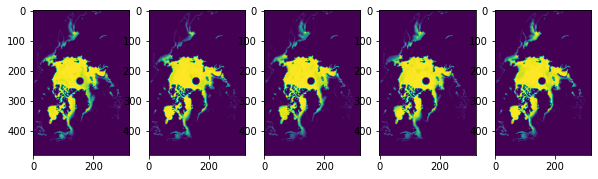

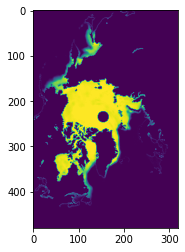

In [21]:
m = 1
plt.figure(figsize=(10,15))
for y in range(x_train.shape[2]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train[0,m-1,y,:,:,0])
plt.show()

plt.imshow(y_train[0,m-1,-1,:,:,0])

# 데이터 자르기
이미지가 클 경우 ConvLSTM모델의 메모리가 부족하여 가로세로 32px씩 이동하며 128x128로 이미지를 잘랐습니다.

학습에는 2019년까지, 2019년도를 평가 데이터로 활용하여 학습 결과를 2019년(가장 최근년도)에 과적합시켰습니다.

In [22]:
#stride = 32
feature_size = 128
x_train_ = []
y_train_ = []
for y in range(x_train.shape[0]):
    for m in range(12):
        for i in range((x_train.shape[3]-feature_size)//stride+1):
            for j in range((x_train.shape[4]-feature_size)//stride+1):
                x_ = x_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                y_ = y_train[y, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
                x_train_.append(x_)
                y_train_.append(y_)

x_train_ = np.array(x_train_)
y_train_ = np.array(y_train_)

x_val_ = []
y_val_ = []

for m in range(12):
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            y_ = y_train[-1, m, :, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]
            x_val_.append(x_)
            y_val_.append(y_)
            
x_val_ = np.array(x_val_)
y_val_ = np.array(y_val_)

In [23]:
x_train_.shape, y_train_.shape, x_val_.shape, y_val_.shape

((25200, 5, 128, 128, 1),
 (25200, 1, 128, 128, 1),
 (1008, 5, 128, 128, 1),
 (1008, 1, 128, 128, 1))

# 학습용 데이터 시각화

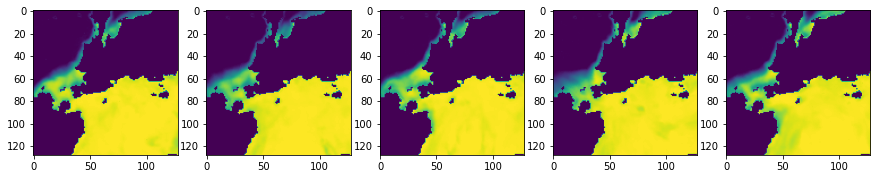

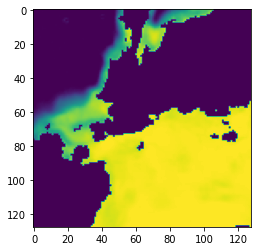

In [24]:
i = 22
plt.figure(figsize=(15,10))
for y in range(x_train_.shape[1]):
    plt.subplot(1,window_size,y+1)
    plt.imshow(x_train_[i,y,:,:,0])
plt.show()
plt.imshow(y_train_[i,-1,:,:,0])

In [25]:
BATCH_SIZE = 16

# 데이터 셋 준비

In [26]:
def train_map_func(x, y):
    x = tf.cast(x, tf.float32)/250
    y = tf.cast(y, tf.float32)
    return x, y

In [27]:
train_dataset = tf.data.Dataset.from_tensor_slices((x_train_, y_train_))
train_dataset = train_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
train_dataset = train_dataset.batch(BATCH_SIZE)
train_dataset = train_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((x_val_, y_val_))
val_dataset = val_dataset.map(train_map_func, num_parallel_calls=tf.data.experimental.AUTOTUNE)
val_dataset = val_dataset.batch(BATCH_SIZE)
val_dataset = val_dataset.prefetch(buffer_size=tf.data.experimental.AUTOTUNE)

In [28]:
next(iter(train_dataset))[0].shape, next(iter(train_dataset))[1].shape

(TensorShape([16, 5, 128, 128, 1]), TensorShape([16, 1, 128, 128, 1]))

In [29]:
next(iter(val_dataset))[0].shape, next(iter(val_dataset))[1].shape

(TensorShape([16, 5, 128, 128, 1]), TensorShape([16, 1, 128, 128, 1]))

AdaBeliefOptimizer를 다음과 같이 실험해 보았으나 일반적인 adam을 사용하는 것이 성능이 더 좋아서 adam으로 학습 시킨 것을 최종 제출하였습니다.

In [30]:
AdaBelief = AdaBeliefOptimizer(learning_rate=1e-3, epsilon=1e-7, rectify=False) 

Please check your arguments if you have upgraded adabelief-tf from version 0.0.1.
Modifications to default arguments:
                           eps  weight_decouple    rectify
-----------------------  -----  -----------------  -------------
adabelief-tf=0.0.1       1e-08  Not supported      Not supported
>=0.1.0 (Current 0.2.0)  1e-14  supported          default: True
SGD better than Adam (e.g. CNN for Image Classification)    Adam better than SGD (e.g. Transformer, GAN)
----------------------------------------------------------  ----------------------------------------------
Recommended epsilon = 1e-7                                  Recommended epsilon = 1e-14
For a complete table of recommended hyperparameters, see
https://github.com/juntang-zhuang/Adabelief-Optimizer
You can disable the log message by setting "print_change_log = False", though it is recommended to keep as a reminder.



# 모델

In [31]:
with strategy.scope():
    model = Sequential()

    model.add(ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True,
                         input_shape=(None, x_train_.shape[2], x_train_.shape[3], 1)))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(ConvLSTM2D(filters=64, kernel_size=3, padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(ConvLSTM2D(filters=128, kernel_size=3, padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(ConvLSTM2D(filters=128, kernel_size=3, padding='same', return_sequences=True))
    model.add(BatchNormalization())
    model.add(Dropout(0.4))

    model.add(Conv3D(filters=1, kernel_size=3, activation='relu', padding='same', data_format='channels_last'))

    model.compile(loss='mae', optimizer=AdaBelief)
    
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv_lst_m2d (ConvLSTM2D)    (None, None, 128, 128, 64 150016    
_________________________________________________________________
batch_normalization (BatchNo (None, None, 128, 128, 64 256       
_________________________________________________________________
dropout (Dropout)            (None, None, 128, 128, 64 0         
_________________________________________________________________
conv_lst_m2d_1 (ConvLSTM2D)  (None, None, 128, 128, 64 295168    
_________________________________________________________________
batch_normalization_1 (Batch (None, None, 128, 128, 64 256       
_________________________________________________________________
dropout_1 (Dropout)          (None, None, 128, 128, 64 0         
_________________________________________________________________
conv_lst_m2d_2 (ConvLSTM2D)  (None, None, 128, 128, 12 8

# 학습

In [32]:
# if not (os.path.isdir('models')):
#     os.makedirs('models')'
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

checkpointer = ModelCheckpoint(filepath = path + 'models/bn_dr_0.4_Adam_{epoch:02d}-{val_loss:.4f}.hdf5', monitor='val_loss',
                               verbose=1, save_best_only=True, mode='min')
early_stopping_callback = EarlyStopping(monitor='val_loss', patience=3)

#hist = model.fit(train_dataset, epochs=50, validation_data=val_dataset, callbacks=[checkpointer, early_stopping_callback])

# 모델 불러오기

In [33]:
model_name = '_bn_dr0.4_Adam_25-4.0921.hdf5'

#model = load_model(path + 'models/%s' % model_name, compile=False)
model = load_model(path + 'models/%s' % model_name, compile=False)

# 2020년 추론 데이터 전처리

2015 ~ 2019년까지 5년간 월별 데이터를 학습과 같은 형태로 전처리




In [34]:
x_test = train_month[:,-1*window_size:,:,:,:1]
x_test = np.swapaxes(x_test , 0, 1)

In [35]:
stride = 32
x_test_ = []
for m in range(12):
    feature = []
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            x_ = x_test[:, m, stride*i:stride*i+feature_size, stride*j:stride*j+feature_size, :1]/250
            feature.append(x_)
    feature = np.array(feature)
    x_test_.append(feature)
x_test_ = np.array(x_test_)

In [36]:
x_test_.shape

(12, 84, 5, 128, 128, 1)

# 추론

In [37]:
preds = []
for m in tqdm(range(12)):
    pred = model.predict(x_test_[m])
    pred = np.where(pred>250, 250, pred)
    preds.append(pred)

100%|██████████| 12/12 [03:57<00:00, 19.80s/it]


# 추론 결과 중복된 영역의 경우 평균을 이용해 앙상블

stride값을 작게해서 테스트 해보았으나 성능에 큰 효과가 없었습니다.

In [38]:
voting_mask = np.zeros((x_train.shape[-3], x_train.shape[-2]))
ones = np.ones((feature_size, feature_size))

for i in range((x_train.shape[3]-feature_size)//stride+1):
    for j in range((x_train.shape[4]-feature_size)//stride+1):
        voting_mask[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += ones

In [39]:
results = []
for m in range(12):
    pred = np.zeros((x_train.shape[-3], x_train.shape[-2]))
    k = 0
    for i in range((x_train.shape[3]-feature_size)//stride+1):
        for j in range((x_train.shape[4]-feature_size)//stride+1):
            pred[stride*i:stride*i+feature_size, stride*j:stride*j+feature_size] += preds[m][k,-1,:,:,0]
            k+=1
    pred /= voting_mask
    results.append(pred[:448, :304])
results = np.array(results)

In [40]:
results.shape

(12, 448, 304)

# 추론 결과 시각화

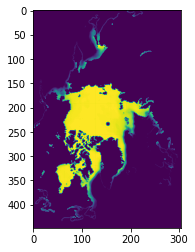

1 



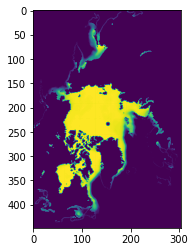

2 



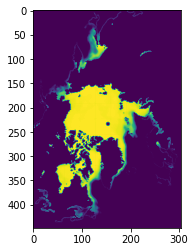

3 



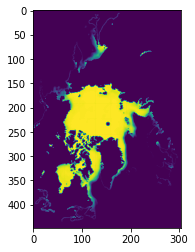

4 



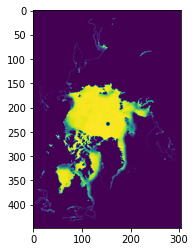

5 



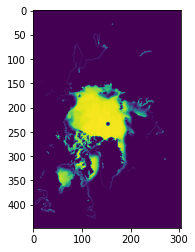

6 



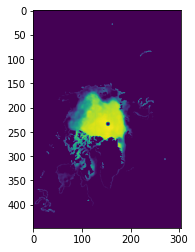

7 



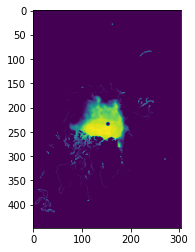

8 



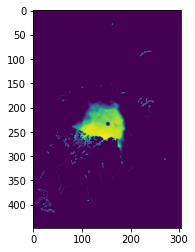

9 



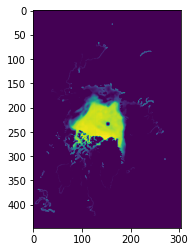

10 



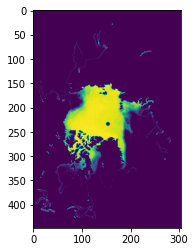

11 



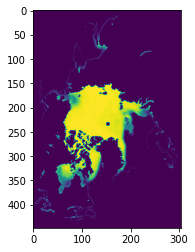

12 



In [41]:
for m in range(12):
    plt.imshow(results[m])
    plt.show()
    print(m+1, '\n')

# 제출 파일 생성

In [42]:
submission = pd.read_csv(path+'sample_submission.csv')
submission.head()

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
1,2019-02,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
2,2019-03,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
3,2019-04,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0
4,2019-05,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


2019년 데이터는 그대로 제출하고 2020년 추론 결과를 추가하여 제출파일을 형성

In [43]:
sub_2019 = submission.loc[:11, ['month']].copy()
sub_2020 = submission.loc[12:, ['month']].copy().reset_index()
sub_2020 = sub_2020.drop('index', axis=1)
print(sub_2020)
sub_2019 = pd.concat([sub_2019, (pd.DataFrame(train_19.reshape([12,-1])))], axis=1)
sub_2020 = pd.concat([sub_2020, (pd.DataFrame(results.reshape([12,-1])))], axis=1)
sub_2019.columns = submission.columns
sub_2020.columns = submission.columns
print(sub_2020)
submission = pd.concat([sub_2019, sub_2020])
submission

      month
0   2020-01
1   2020-02
2   2020-03
3   2020-04
4   2020-05
5   2020-06
6   2020-07
7   2020-08
8   2020-09
9   2020-10
10  2020-11
11  2020-12
      month    0    1    2    3  ...  136187  136188  136189  136190  136191
0   2020-01  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
1   2020-02  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
2   2020-03  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
3   2020-04  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
4   2020-05  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
5   2020-06  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
6   2020-07  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
7   2020-08  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
8   2020-09  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0.0
9   2020-10  0.0  0.0  0.0  0.0  ...     0.0     0.0     0.0     0.0     0

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


# 제출 파일 저장

In [44]:
submission.to_csv(path + 'v2_%d_%s_submission.csv' % (stride, model_name), index=False)

# 제출 파일 확인

In [50]:
submission = pd.read_csv(path+'v2_32__bn_dr0.4_Adam_25-4.0921.hdf5_submission.csv')
test_plot = submission[12:]
test_plot = test_plot.drop('month', axis=1)
test_plot = np.array(test_plot).reshape(12, 448, 304)

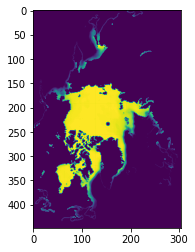

1 



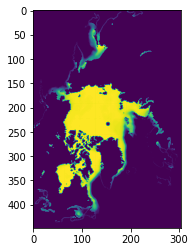

2 



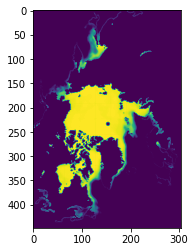

3 



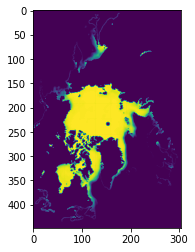

4 



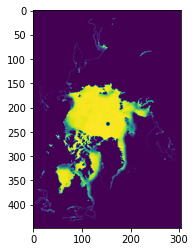

5 



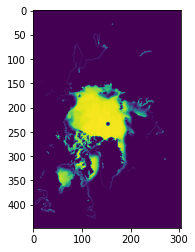

6 



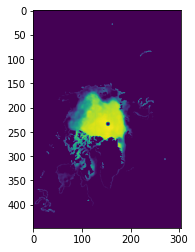

7 



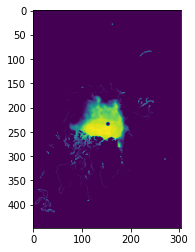

8 



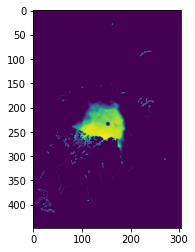

9 



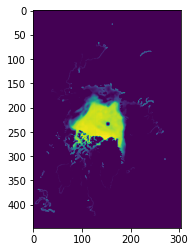

10 



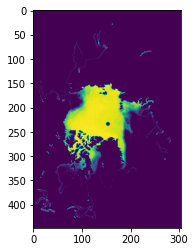

11 



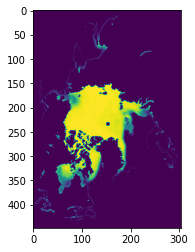

12 



In [51]:
for m in range(12):
    plt.imshow(test_plot[m])
    plt.show()
    print(m+1, '\n')

In [52]:
submission

,month,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,...,136152,136153,136154,136155,136156,136157,136158,136159,136160,136161,136162,136163,136164,136165,136166,136167,136168,136169,136170,136171,136172,136173,136174,136175,136176,136177,136178,136179,136180,136181,136182,136183,136184,136185,136186,136187,136188,136189,136190,136191
0,2019-01,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,2019-02,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,2019-03,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,2019-04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,2019-05,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,2019-06,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,2019-07,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
7,2019-08,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
8,2019-09,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
9,2019-10,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
